In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import pickle
import feather
import tensorflow as tf

from keras.layers import Input, Embedding, LSTM, Dense, merge
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.layers import Convolution1D, GlobalMaxPooling1D, MaxPooling1D
from keras.layers import Embedding
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from IPython.display import SVG
from keras.utils.visualize_util import plot
from keras.utils.visualize_util import model_to_dot
from keras.preprocessing import text
from keras.preprocessing import sequence

from keras_tqdm import TQDMNotebookCallback

from sklearn import metrics

Using TensorFlow backend.


In [2]:
def MapInterestToVector(interest_level):
    if interest_level == 'low':
        return [1,0,0]
    elif interest_level == 'medium':
        return [0,1,0]
    elif interest_level == 'high':
        return [0,0,1]
    else:
        return [0,0,0]

In [3]:
#training_frame = pickle.load( open( '../../Data/RentalListingData/training_set_with_images_and_features.pkl', 'rb' ) )
training_frame = feather.read_dataframe(path='../../Data/RentalListingData/first_dataframe_train_with_feature_clusters')
training_frame['interest_vector'] = training_frame['interest_level'].apply(MapInterestToVector)

In [4]:
training_y = list(training_frame['interest_vector'])
training_y = np.array(training_y).astype(float)

In [5]:
max_features = 4000
maxlen = 250
batch_size = 32
embedding_dims = 60
nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 2

In [6]:
training_descriptions = list(training_frame['description'])
word_tokens = text.Tokenizer(max_features, lower=True, split=" ")
word_tokens.fit_on_texts(training_descriptions)
text_seqs = word_tokens.texts_to_sequences(training_descriptions)
text_matrix = word_tokens.texts_to_matrix(training_descriptions)

In [7]:
seq_train = sequence.pad_sequences(text_seqs, maxlen=maxlen)

In [8]:
training_x = np.array(training_frame.ix[:,[1,2,7,8,11]+list(range(15,876))]).astype(float)

In [9]:
np.shape(training_x)

(49352, 866)

In [55]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


text_seq_input =  Input(shape=(250,), name = 'text_seq_input')
text_matrix_input = Input(shape=(4000,), name = 'text_matrix_input')
clustered_input = Input(shape=(866,), name = 'clustered_input')

model_1 = Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen,
                    dropout=0.1)(text_seq_input)

#model.add(LSTM(32, input_shape=(10, 64)))

#model.add(LSTM(16))

model_1 = Convolution1D(nb_filter=nb_filter,
                        filter_length=5,
                        border_mode='valid',
                        activation='relu',
                        subsample_length=2)(model_1)

# model = MaxPooling1D(pool_length=2, border_mode='valid')(model)

# model = Convolution1D(nb_filter=120,
#                         filter_length=5,
#                         border_mode='valid',
#                         activation='relu',
#                         subsample_length=2)(model)

# model = MaxPooling1D(pool_length=2, border_mode='valid')(model)

# model = Convolution1D(nb_filter=60,
#                         filter_length=5,
#                         border_mode='valid',
#                         activation='relu',
#                         subsample_length=1)(model)


#model_1 = GlobalMaxPooling1D()(model_1)
model_1 = MaxPooling1D(pool_length=2, border_mode='valid')(model_1)


model_1 = Dense(250, activation='relu')(model_1)
model_1 = Dropout(0.2)(model_1)

model_1_out = Flatten()(model_1)
# model = Activation('relu')(model)

aux_1_output = Dense(3, activation = 'softmax', name = 'aux_1_out')(model_1_out)

# model.add(Dense(120))
# model.add(Dropout(0.2))
# model.add(Activation('relu'))

model_2 = Dense(250, activation='sigmoid')(clustered_input)
model_2_out = Dropout(0.2)(model_2)

aux_2_output = Dense(3, activation = 'softmax', name = 'aux_2_out')(model_2_out)


model_3 = Dense(500, activation = 'sigmoid')(text_matrix_input)
model_3 = Dropout(0.5)(model_3)

model_3 = Dense(50, activation = 'sigmoid')(model_3)
model_3 = Dropout(0.3)(model_3)

model_3 = Dense(120, activation = 'relu')(model_3)
model_3_out = Dropout(0.6)(model_3)

aux_3_output = Dense(3, activation = 'softmax', name = 'aux_3_out')(model_3_out)


#model_2_out = Flatten()(model_2)
# merge models

model = merge([model_1_out, model_2_out, model_3_out], mode='concat')

model = Dense(30, activation='tanh')(model)

model = Dense(3)(model)
model = Activation('softmax')(model)


class_model = Model(input = [text_seq_input, clustered_input, text_matrix_input], output = [model, aux_1_output, aux_2_output, aux_3_output])
class_model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'], loss_weights = [0.5, 0.25, 0.25, 0.25])

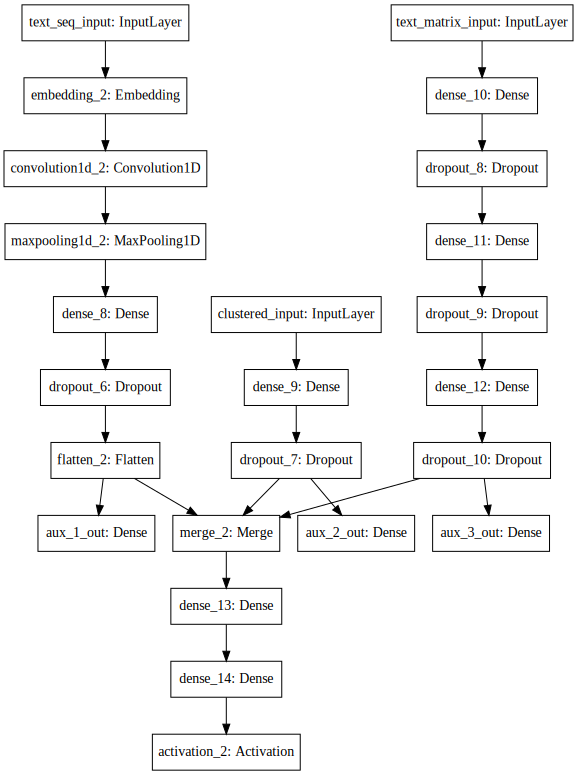

In [56]:
SVG(model_to_dot(class_model).create(prog='dot', format='svg'))

In [57]:
nb_epoch = 7
batch_size = 32

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')   
history = LossHistory()

In [58]:
train_indices = list(range(len(training_x)))
np.random.shuffle(train_indices)

In [59]:
p = 0.85

In [60]:
range_length = int(p*(len(train_indices)))

In [61]:
class_model.fit([seq_train[:range_length],training_x[:range_length],text_matrix[:range_length]], [training_y[:range_length],training_y[:range_length],training_y[:range_length],training_y[:range_length]], batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.05, verbose=0, shuffle=True, callbacks=[TQDMNotebookCallback(leave_inner = True, leave_outer = True), history])

C:\Users\Stoja\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\ops\gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


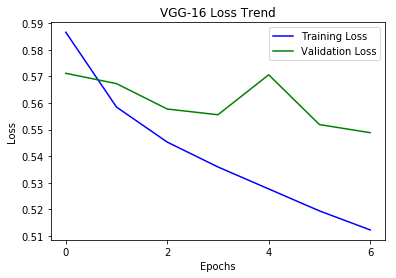

In [62]:

loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

In [88]:
predictions = class_model.predict([seq_train[range_length:],training_x[range_length:],text_matrix[range_length:]], verbose=0)

In [89]:
predictions = predictions[0]

In [90]:
np.shape(predictions)

(7403, 3)

In [91]:
indx = 0

for i in np.random.randint(0,len(predictions),15):
    if predictions[i][0] >= 0.5: 
        print('I am {:.2%} sure this property yields low interest'.format(predictions[i][0]))
        #print('The price on this property is ${0} per month'.format(training_aux_clean[i][0]))
        if list(training_y[i]) == [1,0,0]:
            print('I was right!')
        else:
            print('I was wrong ')
        print(i)
    elif predictions[i][1] >= 0.5:
        print('I am {:.2%} sure this property yields medium interest'.format(predictions[i][1]))
        #print('The price on this property is ${0} per month'.format(training_aux_clean[i][0]))
        if list(training_y[i]) == [0,1,0]:
            print('I was right!')
        else:
            print('I was wrong ')
        print(i)
    elif predictions[i][2] >= 0.5:
        print('I am {:.2%} sure this propertry yields high interest'.format(predictions[i][2]))
        #print('The price on this property is ${0} per month'.format(training_aux_clean[i][0]))
        if list(training_y[i]) == [0,0,1]:
            print('I was right!')
        else:
            print('I was wrong ')
        print(i)
    else:
        print('Im not really sure what interest this property yields')
        print(i)
        
    
#     plt.imshow(training_x_clean[i])
#     plt.show()

Im not really sure what interest this property yields
5692
I am 88.50% sure this property yields low interest
I was right!
5682
I am 95.77% sure this property yields low interest
I was wrong 
6616
I am 64.36% sure this property yields low interest
I was right!
2855
I am 55.10% sure this property yields medium interest
I was wrong 
4527
Im not really sure what interest this property yields
2235
I am 62.55% sure this property yields low interest
I was wrong 
3395
I am 88.37% sure this property yields low interest
I was wrong 
6376
I am 62.49% sure this property yields medium interest
I was wrong 
4458
I am 50.99% sure this property yields low interest
I was right!
3298
I am 58.58% sure this property yields low interest
I was right!
7288
I am 92.06% sure this property yields low interest
I was wrong 
3965
I am 51.84% sure this property yields low interest
I was right!
2054
I am 74.61% sure this property yields low interest
I was wrong 
5919
Im not really sure what interest this property y

In [92]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = metrics.roc_curve(training_y[range_length:, i], predictions[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

In [93]:
roc_auc

{0: 0.76579822568132427, 1: 0.70106073460295315, 2: 0.80430834291609199}